# Large scale imaging and analysis of neuronal activity

### Optical Imaging

>Discuss the difference between Two-photon Point Scanning Microscopy and One-photon Light Sheet Microscopy according to the criteria discussed during the course

---------------------------------------
Answer:

---------------------------------------

### Analysis of Large scale datasets

>According to the article:

>**Cortical activity in the null space: permitting preparation without movement**
*Kaufman, Churchland, Ryu, Shenoy. *
>[doi: 10.1038/nn.3643.](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3955357/)

>If muscle are driven by a linear combination of neural firing rates:

>$$M=WN$$

>where M, W and N are matrices. Each row of M contains the activity of one muscle, and each row of N contains the activity of one neuron. Columns correspond to different times. W contains the weights for the linear mapping from neurons to muscles. 

>To what vector subspace does N belong in absence of movements. Explain how this differs from a gating mechanism?

---------------------------------------
Answer:

---------------------------------------

## Analysis of large neuronal datasets 

### Presentation of the experiments:

A larva zebrafish expressing the Calcium indicator GCaMP5 was positioned in agarose. A moving gratings was presented at different orientation below the larva. The neuronal activity was recorded in a section of the larva's brain using a two-photon Light-Sheet microscope. 

<img src="LarvaOMR.png">

### Load Python library

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import cmath as cm

from scipy import stats
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

%matplotlib inline
sns.set_style("white")
sns.set_context("poster")

# Define color for the plot:
Bl = [0.26289888084943275, 0.43460202543313281, 0.69396385215237932, 1.0]
Re = [0.83929258649141159, 0.18454440685704504, 0.15286428870053897, 1.0]

/home/adrien/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


### Load File of neuronal activity

In [4]:
Mat=sio.loadmat('SpimData.mat')
Spim=Mat['Spim']
Spim=Spim[0][0]

The vector **Stim** contains the value of the grid orientation during the recording. When Stim is zero, no stimuli were presented. 9 Orientation are presented 10 times during the recording

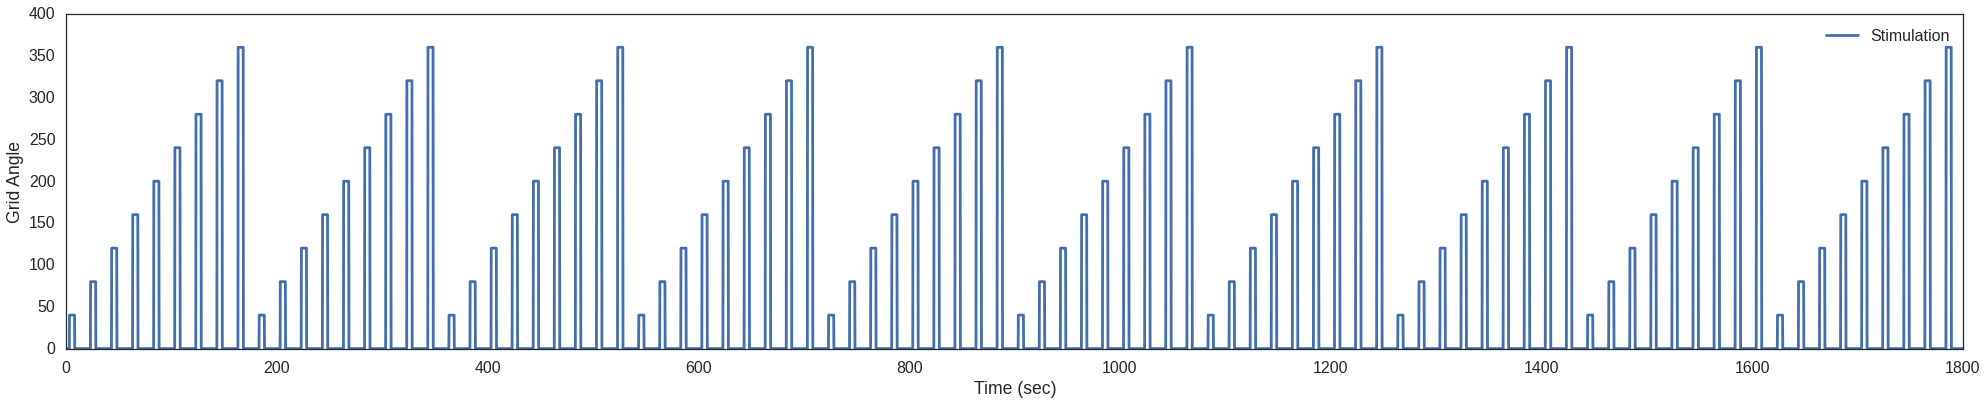

In [7]:
Stim=np.transpose(Spim['Stim'])
Time=np.linspace(0,1800,18000)
plt.figure(figsize=(34,6))
plt.plot(Time,Stim,label='Stimulation',color=Bl)
plt.xlabel('Time (sec)')
plt.ylabel('Grid Angle')
plt.legend()

The vector **DFF** contains the value of $\frac{\Delta F}{F}$ for each of the 4558 neurons recorded at 10 Hz


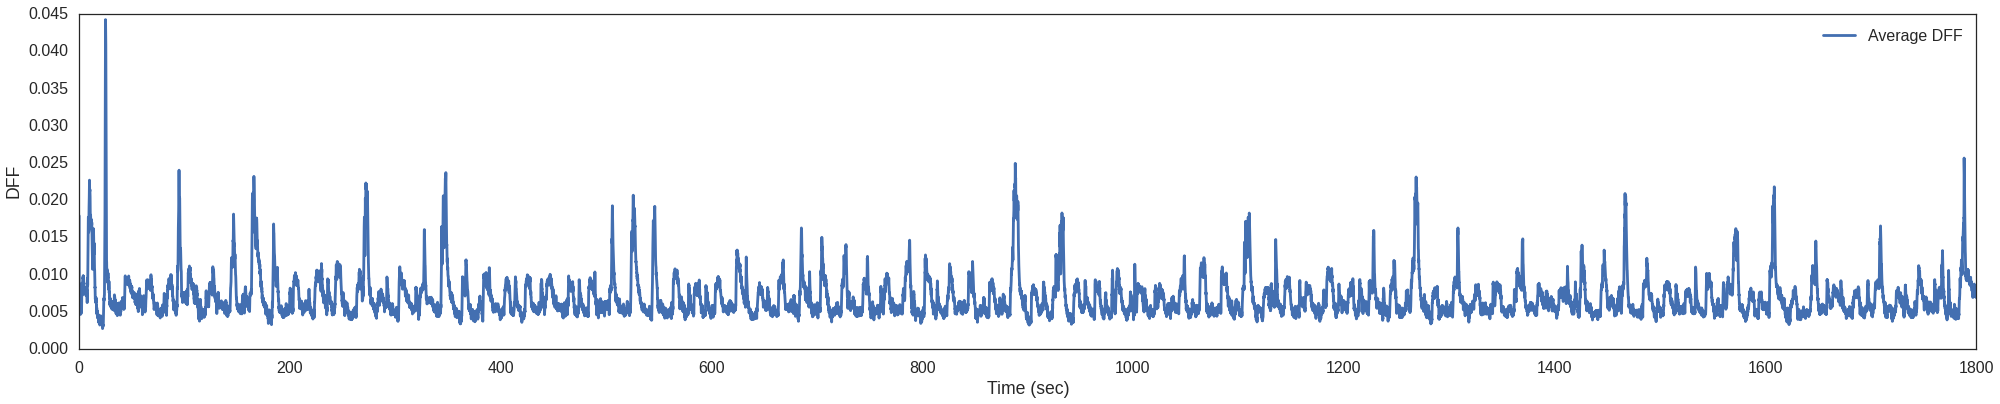

In [9]:
DFF=np.transpose(Spim['DFF'])
plt.figure(figsize=(34,6))
plt.plot(Time,np.mean(DFF,1),label='Average DFF',color=Bl)
plt.xlabel('Time (sec)')
plt.ylabel('DFF')
plt.legend()

(-0.5, 719.5, 499.5, -0.5)

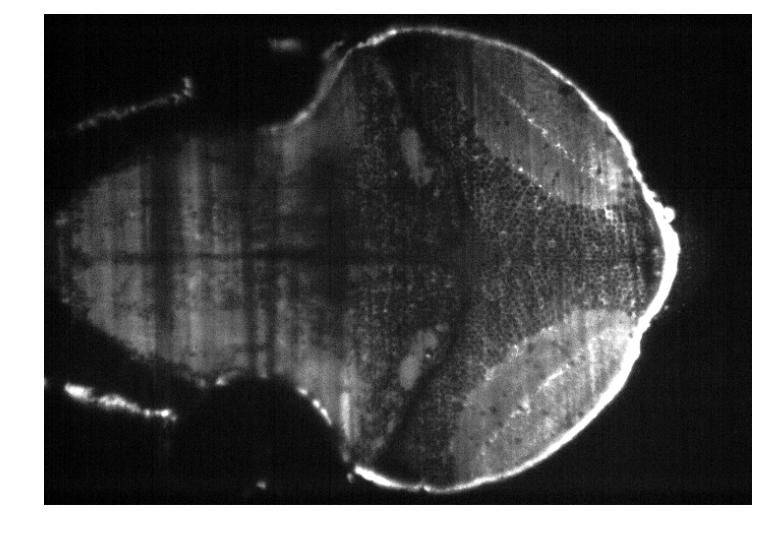

In [10]:
ImgBrain=1-(Spim['ImgBrain'])
plt.imshow(ImgBrain);
plt.axis('off')


> From what you know about light sheet imaging, explain the presence of vertical **black stripes** on the image



---------------------------------------
Answer:

---------------------------------------

**Pixel Neuron** allows to visualize position of each neuron

(-0.5, 719.5, 499.5, -0.5)

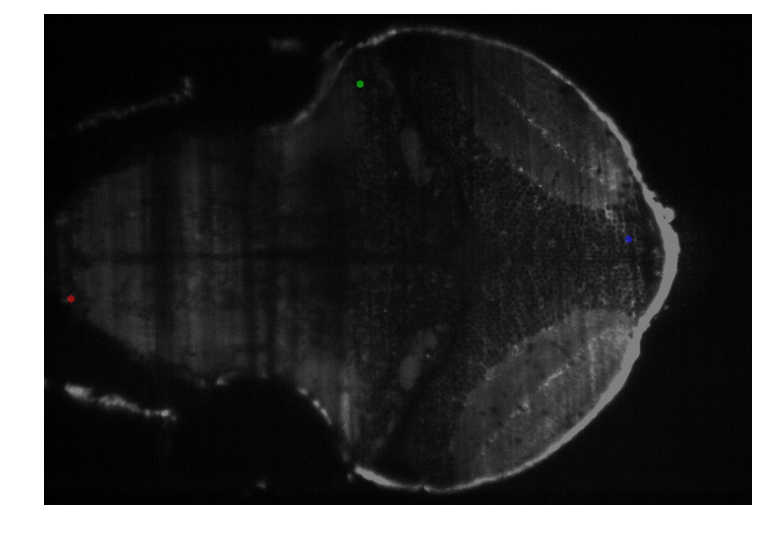

In [11]:
PixelNeuron=Spim['PixelNeuron'][0]

img=1-ImgBrain
rows, cols = ImgBrain.shape
color_mask = np.zeros((rows, cols, 3))

# Neuron 100 in Red
id=PixelNeuron[100]-1
rowsN,colsN=np.unravel_index(id, (rows,cols), order='F')
color_mask[rowsN,colsN]=[1,0,0]
# Neuron 2000 in Green
id=PixelNeuron[2000]-1
rowsN,colsN=np.unravel_index(id, (rows,cols), order='F')
color_mask[rowsN,colsN]=[0,1,0]
# Neuron 4500 in Blue
id=PixelNeuron[4500]-1
rowsN,colsN=np.unravel_index(id, (rows,cols), order='F')
color_mask[rowsN,colsN]=[0,0,1]

# Set Transparency parameter:
alpha=0.5
img_color = np.dstack((img, img, img))

plt.imshow((1-alpha)*img_color+alpha*color_mask)
plt.axis('off')


## Mass univariate quantification of neuronal activity

>First, we want to compute the tuning curve of each neuron. For that, you will compute the average $\frac{\Delta F}{F}$ in function of the angle of the stimulus

In [12]:
TuningCurv=np.zeros(shape=[9,4558])
i=0;
AngleRange=[360,40,80,120,160,200,240,280,320]
for angle in AngleRange:
    Id=np.nonzero(Stim==(angle))[0]
    AverageResponse=np.nanmean(DFF[Id,:],0)
    TuningCurv[i,:]=AverageResponse
    i=i+1

>Display in polar coordinate the tuning curve of the neuron 3853

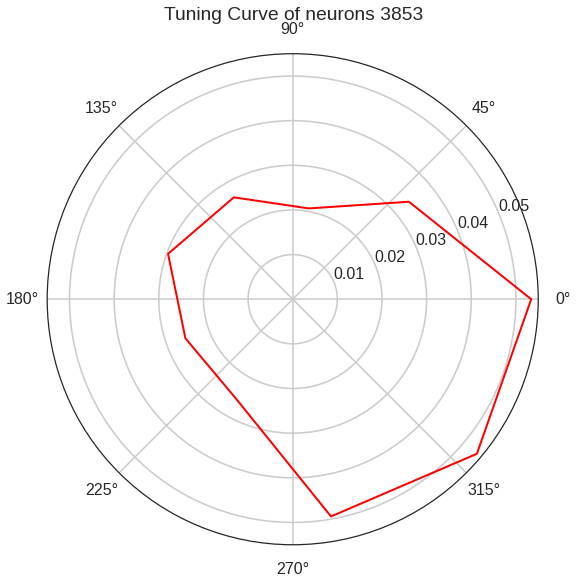

In [13]:
i=3853
r =TuningCurv[:,i]# np.mean(TuningCurv,1)#
r=np.append(r,r[0])
theta = np.linspace(0,2*np.pi,10)


ax = plt.subplot(111, projection='polar')
ax.plot(theta, r, color='r', linewidth=2)
ax.grid(True)
ax.set_title("Tuning Curve of neurons "+str(i), va='bottom')
plt.show()


>To what direction/orientation is this neurons selective?

---------------------------------------
Answer:

---------------------------------------

### Compute Circular Statistics:

>If we consider a neuron whose tuning curve is the following:

><img src="ExampleTuningCurve.png">

>Why the mean and standard deviation fail to capture the properties distribution defined over angles?


>Instead, we want to compute circular statistic. For each neuron, you will compute its circular average as defined by $m=\arg(R)$ and the variance as $V=1-abs(R)$ where R is defined as:

>$$R=\frac{\sum_k T_k e^{i\theta_k}}{\sum_k T_k}$$

>where $T_k$ is the neuronal tuning in the direction $\theta_k$


---------------------------------------
Answer:

---------------------------------------

In [14]:
R=np.zeros(shape=[DFF.shape[1],1], dtype=complex)

Angle=np.linspace(0,2.*np.pi,10)
for i in range(0,DFF.shape[1]):

    Vect=0;Norm=0;
    for k in range(0,9):
        Vect=Vect+TuningCurv[k,i]*cm.exp(1j*Angle[k])
        Norm=Norm+TuningCurv[k,i]
    R[i]=Vect/Norm

m=np.angle(R)
V=1-np.absolute(R)       

[(-3.141592653589793, 3.141592653589793)]

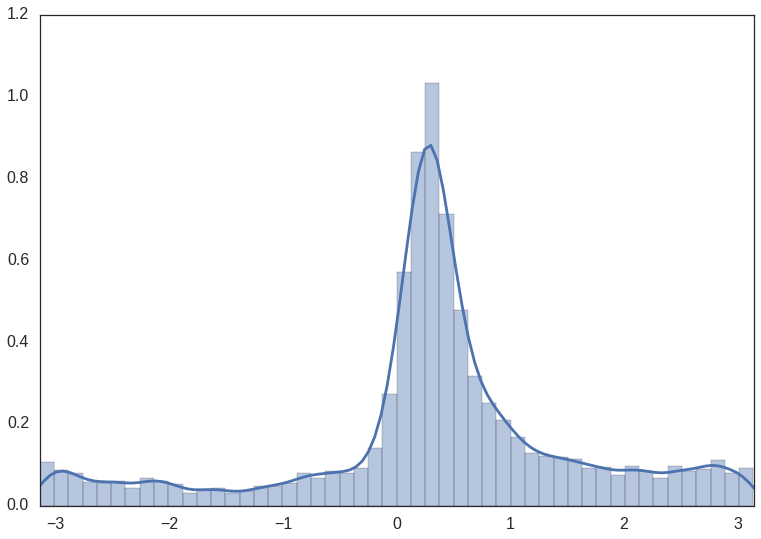

In [15]:
# Display distribution of prefered angle
sns.distplot(m).set(xlim=(-np.pi,np.pi))

> Why is this distribution not uniform? Why is the peak around 0°? Consider the behavior associated with different angles.

---------------------------------------
Answer:

---------------------------------------

### Dynamic range

>We want to compute how much signal a neuron conveys, for that we compute its dynamic range defined as

>$$ DR=\frac{Max-Min}{Max+Min}$$

> Where Max and Min are respectively the 90th and 10th percentile of the neuron


In [16]:
DR=np.zeros(shape=[DFF.shape[1],1])
for i in range(0,DFF.shape[1]):
    Max=np.nanpercentile(DFF[:,i], 90)
    Min=np.nanpercentile(DFF[:,i], 10)
    DR[i]=(Max-Min)/(Max+Min)

### Use HSV color to represent Neuronal Response

> In the HSV scale, each color is defined by three values. We will use it to represent relevant information about neuron response.
* The Hue will represent the average angle
* The Saturation will represent 1-circular variance
* The Value will represent the Dynamic range of each neuron

><img src="HSV.jpg">

> Using this colormap, Explain the shape of the tuning curve associated with the color white, black or green?

---------------------------------------
Answer:

---------------------------------------

In [17]:
# First define a function for normalizing values to 0-1:

def Normalize(x):
    xNorm=(1./(1+np.exp(-(x-np.mean(x))/(0.5*np.std(x)))))
    xNorm=xNorm-min(xNorm);
    xNorm=xNorm/max(xNorm);
    return xNorm

DRNorm=Normalize(DR)
VNorm=Normalize(1-V)
# Wrap angle between 0 and 2pi
id=np.nonzero(m<0)[0]
m[id]=m[id]+2*np.pi
# Normalize angle to match the HSV scale
mNorm=m/(2*np.pi)

(-0.5, 719.5, 499.5, -0.5)

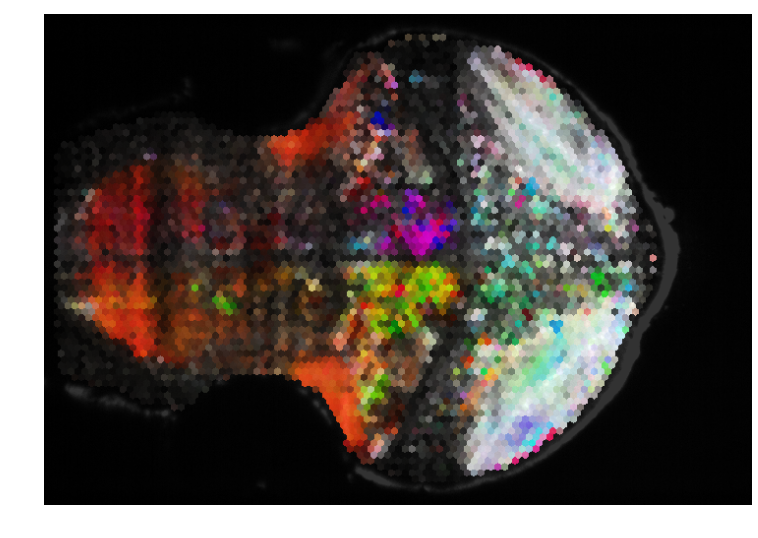

In [18]:
import colorsys
img=1-ImgBrain
rows, cols = ImgBrain.shape
color_mask = np.zeros((rows, cols, 3))

for i in range(0,DFF.shape[1]):
    id=PixelNeuron[i]
    rowsN,colsN=np.unravel_index(id, (rows,cols), order='F')
    h=mNorm[i]
    s=VNorm[i]
    v=DRNorm[i]
    colorRGB=colorsys.hsv_to_rgb(h, s, v)
    color_mask[rowsN,colsN]=[colorRGB[0][0],colorRGB[1][0],colorRGB[2][0]]

# Set Transparency parameter:
alpha=0.8
img_color = np.dstack((img, img, img))
plt.imshow((1-alpha)*img_color+alpha*color_mask)
plt.axis('off')


> Speculate on the behavioral role of two group bilaterally asymetric in the hindbrain
> 

> Speculate on the behavioral role of two group bilaterally asymetric in the hindbrain

> Briefly compare the response of the neuropile with the results published in the article :

>**Neuropile of the tectum Parametric Functional Maps of Visual Inputs to the Tectum**
*Nikolaou et al.*
>[doi: 10.1016/j.neuron.2012.08.040.](http://www.sciencedirect.com/science/article/pii/S0896627312008069)


> What is the color dominating the motor regions? Why?

---------------------------------------
Answer:

---------------------------------------

## Dimensionality reduction of neuronal activity

>We aims at applying the dimensionality reduction technique learn during the course to gain insight into the neuronal dynamics

### Principal Component Analysis:

> Apply PCA to the matrix of neuronal activity during the stimulation.


In [19]:
Id=np.nonzero(Stim>0)[0]
NeurStim=DFF[Id,:]
NeurStim=stats.zscore(NeurStim)

pca = PCA(n_components=10)
pca.fit(NeurStim)
PCA(copy=True, n_components=10, whiten=False)

/home/adrien/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


PCA(copy=True, n_components=10, whiten=False)

In [20]:
X = pca.transform(NeurStim)
loadings = pca.components_
print(X.shape)
print(loadings.shape)

(4496, 10)
(10, 4558)


> Display the loadings and the score for relevant PCs

(-0.5, 719.5, 499.5, -0.5)

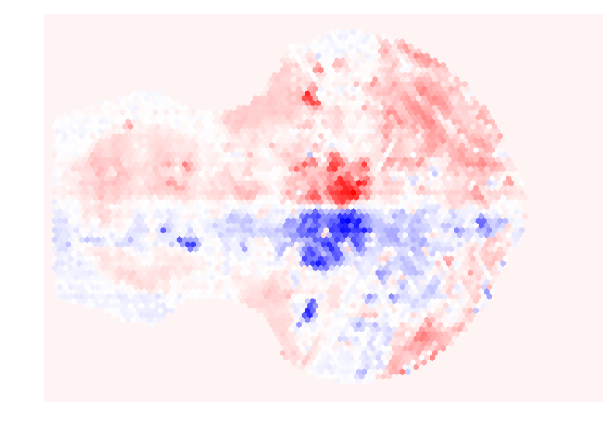

In [21]:
n=3
plt.figure(figsize=(10,10));
rows, cols = ImgBrain.shape
color_mask = np.zeros((rows, cols))
for i in range(0,loadings.shape[1]):
    id=PixelNeuron[i]
    rowsN,colsN=np.unravel_index(id, (rows,cols), order='F')
    color_mask[rowsN,colsN]=loadings[n,i]
# Use different colormap Blues hot
plt.imshow(color_mask,cmap=mpl.cm.bwr)
plt.axis('off')


> Try to interpret to what could correspond the different PCs in term of relevant motor or visual signals.


---------------------------------------
Answer:

---------------------------------------

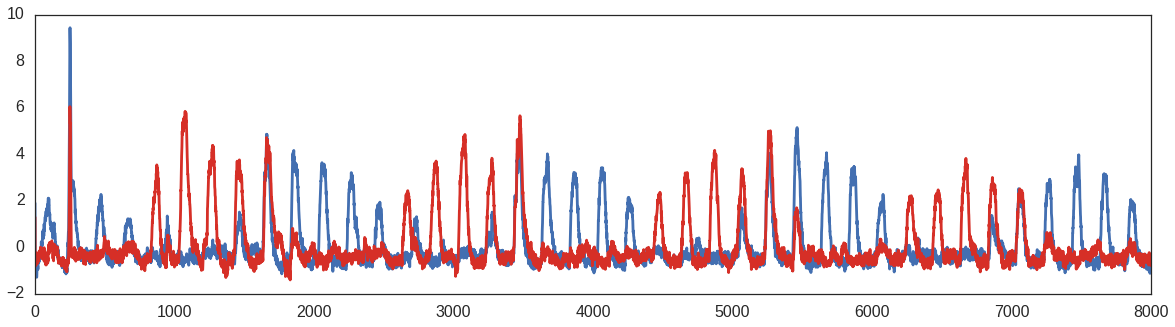

In [22]:
idPos=np.nonzero(loadings[3,:]>0.04)[0]
idNeg=np.nonzero(loadings[3,:]<-0.04)[0]
Xpos=stats.zscore(np.sum(DFF[:,idPos],1))
Xneg=stats.zscore(np.sum(DFF[:,idNeg],1))
plt.figure(figsize=(20,5));
plt.plot(Xneg[0:8000],color=Bl)
plt.plot(Xpos[0:8000],color=Re)

## Display Neuronal activity in Low Dimensional space

> What are the two PCs that best differentiate the response to different angles

(4496, 1)


/home/adrien/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


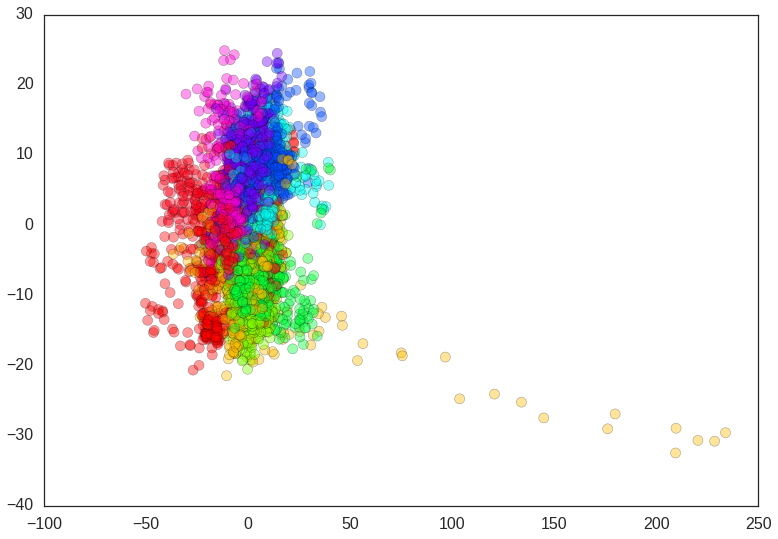

In [21]:
X1=X[:,1]
X2=X[:,3]

s=Stim[Id]
Color=s/360.
print(Color.shape)
c=plt.scatter(X1,X2, c=Color, s=100, cmap=mpl.cm.hsv)
c.set_alpha(0.4)

---------------------------------------
Answer:

---------------------------------------

### Using t-SNE to reduce the dimensionality of neuronal activity

> We want to apply a non-linear dimensionality reduction techniques 


In [22]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
YlowDim=model.fit_transform(NeurStim) ##take ~20min to complete

/home/adrien/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


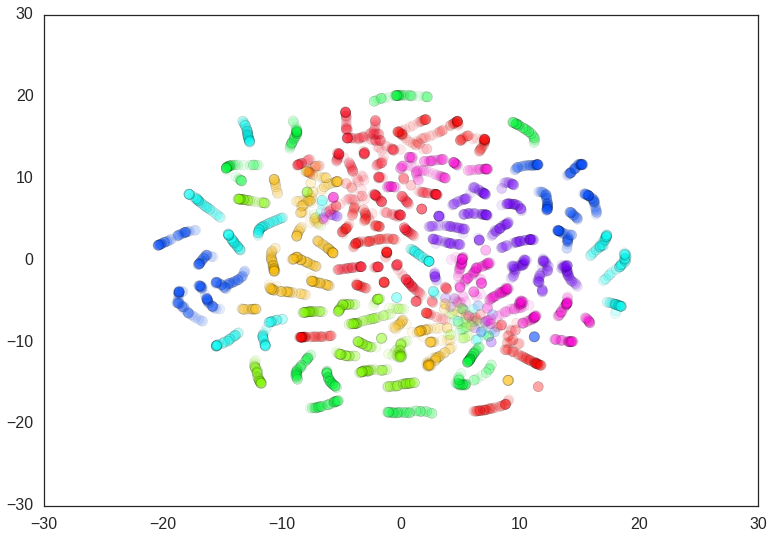

In [23]:
X1=YlowDim[:,0]
X2=YlowDim[:,1]

s=Stim[Id]
Color=s/360.
c=plt.scatter(X1,X2, c=Color, s=100, cmap=mpl.cm.hsv)
c.set_alpha(0.1)

> Two levels of clusterization can be observed, What do they correspond to?
> Discuss the advantage/drawback of t-SNE compared to PCA for interpreting neuronal activity or building a decoder (infer the angle of the grid presented from the neuronal activity)

---------------------------------------
Answer:

---------------------------------------